In [ ]:
# makes footprints for 19-port PL

In [24]:
import glob as glob
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.sparse.linalg import lsmr

%matplotlib inline
#%matplotlib qt

In [2]:
stem = '/Users/bandari/Documents/git.repos/photonics_spectroscopy/notebooks_for_development/data/19pl/'

In [3]:
# read in a test frame / dark

dark_apapane = stem + 'raw/apapanedark.fits'
test_array = fits.open(dark_apapane)[0].data
dark = test_array

In [4]:
# read in a broadband frame

raw_bb_frame_19pl = stem + 'dark_subted/19PL_bb_irnd1.0_optnd3.0.fits'
bb_array = fits.open(raw_bb_frame_19pl)[0].data

# dark subtract
bb_array = np.subtract(bb_array,dark)

In [5]:
# ersatz variance frame

hdul = fits.open('./data/stacked.fits')
test_data = hdul[0].data[0,:,:] # all 3 spectra
array_variance = hdul[0].data[1,:,:]

# replace zeros
array_variance[array_variance == 0] = np.median(array_variance)

In [6]:
# relative positions of all the outputs 
# (can move around with a common offset in (x,y))

rel_pos = {'0':(203,81),
           '1':(193,115),
           '2':(202,113),
           '3':(210,111),
           '4':(187,108),
           '5':(196,106),
           '6':(204,105),
           '7':(213,103),
           '8':(181,101),
           '9':(190,100),
           '10':(198,98),
           '11':(207,96),
           '12':(215,94),
           '13':(184,93),
           '14':(192,91),
           '15':(201,90),
           '16':(209,88),
           '17':(186,84),
           '18':(195,83)}

In [7]:
'''
for key in rel_pos.values():
    plt.scatter(key[0],key[1])
plt.show()
'''

'\nfor key in rel_pos.values():\n    plt.scatter(key[0],key[1])\nplt.show()\n'

In [8]:
# gaussian profile (kind of confusing: coordinates are (lambda, x), instead of (x,y) )
def gaus1d(x_left, len_spec, x_pass, lambda_pass, mu_pass, sigma_pass=1):
    '''
    x_left: x coord of leftmost pixel of spectrum (y coord is assumed to be mu_pass)
    len_spec: length of spectrum [pix]
    x_pass: grid of y-coords in coord system of input
    lambda_pass: grid of x-coords in coord system of input
    mu_pass: profile center (in x_pass coords)
    sigma_pass: profile width (in x_pass coords)
    '''
    
    # condition for lambda axis to be inside footprint
    lambda_cond = np.logical_and(lambda_pass >= x_left, lambda_pass < x_left+len_spec)
    
    #plt.imshow(lambda_cond)
    #plt.show()
    
    # profile spanning entire array
    profile = (1./(sigma_pass*np.sqrt(2.*np.pi))) * np.exp(-0.5 * np.power((x_pass-mu_pass)/sigma_pass,2.) )
    
    # mask regions where there is zero signal
    profile *= lambda_cond
    
    # normalize columns of nonzero signal
    profile = np.divide(profile, np.nanmax(profile))
    
    # restore regions of zero signal as zeros (instead of False)
    profile[~lambda_cond] = 0.
    
    return profile

In [9]:
# wrapper make the enclosing profile of a spectrum

def simple_profile(array_shape, x_left, y_left, len_spec, sigma_pass=1):
    # make simple 1D Gaussian profile in x-direction
    '''
    shape_array: shape of array
    x_left: x-coord of leftmost point of spectrum
    y_left: y-coord of leftmost point of spectrum
    len_spec: length of spectrum (in x-dir)
    sigma_pass: sigma width of profile
    '''
    #(x_left, len_spec, x_pass, mu_pass, sigma_pass)
    array_profile = np.zeros(array_shape)

    xgrid, ygrid = np.meshgrid(np.arange(0,np.shape(array_profile)[1]),np.arange(0,np.shape(array_profile)[0]))
    array_profile = gaus1d(x_left=x_left, len_spec=len_spec, x_pass=ygrid, lambda_pass=xgrid, mu_pass=y_left, sigma_pass=1)

    #plt.imshow(array_profile)
    #plt.show()
    
    # normalize it such that the marginalization in x (in (x,lambda) space) is 1
    # (with a perfect Gaussian profile in x this is redundant)
    
    test2 = array_profile[:,x_left:x_left+len_spec]
    
    array_profile[:,x_left:x_left+len_spec] = np.divide(array_profile[:,x_left:x_left+len_spec],np.sum(array_profile[:,x_left:x_left+len_spec], axis=0))
    
    return array_profile

In [11]:
# make convas_array

canvas_array = np.zeros(np.shape(test_array))

x_offset = 17-181
y_offset = -1

dict_profiles = {}

# loop over each spectrum's starting position
#for coord_xy in rel_pos.values():
for key, coord_xy in rel_pos.items():
    
    print(key, coord_xy)

    profile_this_array = simple_profile(array_shape=np.shape(test_array), 
                                x_left=np.add(coord_xy[0],x_offset), 
                                y_left=np.add(coord_xy[1],y_offset), 
                                len_spec=8, 
                                sigma_pass=1)
    
    canvas_array += profile_this_array
    
    # save single profiles in an array
    dict_profiles[key] = profile_this_array

# check overlap is good
plt.imshow(np.add((1e4)*canvas_array,bb_array), origin='lower')
plt.savefig('junk_overlap.png')
#plt.show()

0 (203, 81)
1 (193, 115)
2 (202, 113)
3 (210, 111)
4 (187, 108)
5 (196, 106)
6 (204, 105)
7 (213, 103)
8 (181, 101)
9 (190, 100)
10 (198, 98)
11 (207, 96)
12 (215, 94)
13 (184, 93)
14 (192, 91)
15 (201, 90)
16 (209, 88)
17 (186, 84)
18 (195, 83)


In [12]:
# fake data for testing (just simple profiles)

bb_fake = canvas_array

In [13]:
plt.imshow(bb_fake)
plt.show()

In [29]:
# 19 spectra: compactified

# define test data
#D = bb_array
D = bb_fake

# extent of detector in x-dir
x_extent = np.shape(test_array)[1]
y_extent = np.shape(test_array)[0]

# initialize dict to hold flux for each spectrum
eta = {'0':np.zeros(x_extent),
       '1':np.zeros(x_extent),
       '2':np.zeros(x_extent),
       '3':np.zeros(x_extent),
       '4':np.zeros(x_extent),
       '5':np.zeros(x_extent),
       '6':np.zeros(x_extent),
       '7':np.zeros(x_extent),
       '8':np.zeros(x_extent),
       '9':np.zeros(x_extent),
       '10':np.zeros(x_extent),
       '11':np.zeros(x_extent),
       '12':np.zeros(x_extent),
       '13':np.zeros(x_extent),
       '14':np.zeros(x_extent),
       '15':np.zeros(x_extent),
       '16':np.zeros(x_extent),
       '17':np.zeros(x_extent),
       '18':np.zeros(x_extent)}


# loop over cols
for col in range(0,x_extent): 
    
    # initialize matrix
    c_mat = np.zeros((19,19), dtype='float')
    b_mat = np.zeros((19), dtype='float')


    # loop over pixels in col
    for i in range(0,y_extent):
        
        for mat_row in range(0,len(dict_profiles)):
            
            for mat_col in range(0,len(dict_profiles)):
    
                c_mat[mat_row][mat_col] += dict_profiles[str(int(mat_row))][i,col] * dict_profiles[str(int(mat_col))][i,col] / array_variance[i,col]

            # b_mat is just 1D, so use mat_row as index
            b_mat[mat_row] += D[i,col] * dict_profiles[str(int(mat_row))][i,col] / array_variance[i,col]

            '''
            b_mat[1] += D[i,col] * dict_profiles['1'][i,col] / array_variance[i,col]

            b_mat[2] += D[i,col] * dict_profiles['2'][i,col] / array_variance[i,col]

            b_mat[3] += D[i,col] * dict_profiles['3'][i,col] / array_variance[i,col]

            b_mat[4] += D[i,col] * dict_profiles['4'][i,col] / array_variance[i,col]

            b_mat[5] += D[i,col] * dict_profiles['5'][i,col] / array_variance[i,col]

            b_mat[6] += D[i,col] * dict_profiles['6'][i,col] / array_variance[i,col]

            b_mat[7] += D[i,col] * dict_profiles['7'][i,col] / array_variance[i,col]

            b_mat[8] += D[i,col] * dict_profiles['8'][i,col] / array_variance[i,col]

            b_mat[9] += D[i,col] * dict_profiles['9'][i,col] / array_variance[i,col]

            b_mat[10] += D[i,col] * dict_profiles['10'][i,col] / array_variance[i,col]

            b_mat[11] += D[i,col] * dict_profiles['11'][i,col] / array_variance[i,col]

            b_mat[12] += D[i,col] * dict_profiles['12'][i,col] / array_variance[i,col]

            b_mat[13] += D[i,col] * dict_profiles['13'][i,col] / array_variance[i,col]

            b_mat[14] += D[i,col] * dict_profiles['14'][i,col] / array_variance[i,col]

            b_mat[15] += D[i,col] * dict_profiles['15'][i,col] / array_variance[i,col]

            b_mat[16] += D[i,col] * dict_profiles['16'][i,col] / array_variance[i,col]

            b_mat[17] += D[i,col] * dict_profiles['17'][i,col] / array_variance[i,col]

            b_mat[18] += D[i,col] * dict_profiles['18'][i,col] / array_variance[i,col]
            '''

    # by symmetry
    c_mat[1][0] = np.copy(c_mat[0][1])
    c_mat[2][1] = np.copy(c_mat[1][2])
    c_mat[3][2] = np.copy(c_mat[2][3])
    c_mat[4][3] = np.copy(c_mat[3][4])
    c_mat[5][4] = np.copy(c_mat[4][5])
    c_mat[6][5] = np.copy(c_mat[5][4])
    c_mat[7][6] = np.copy(c_mat[6][7])
    c_mat[8][7] = np.copy(c_mat[7][8])
    c_mat[9][8] = np.copy(c_mat[8][9])
    c_mat[10][9] = np.copy(c_mat[9][10])
    c_mat[11][10] = np.copy(c_mat[10][11])
    c_mat[12][11] = np.copy(c_mat[11][12])
    c_mat[13][12] = np.copy(c_mat[12][13])
    c_mat[14][13] = np.copy(c_mat[13][14])
    c_mat[15][14] = np.copy(c_mat[14][15])
    c_mat[16][15] = np.copy(c_mat[15][16])
    c_mat[17][16] = np.copy(c_mat[16][17])
    c_mat[18][17] = np.copy(c_mat[17][18])
    
    #print(c_21)
    #print(c_31)
    
    #plt.clf()
    #c_mat_display = np.array([[c_11, c_12, c_13],[c_21, c_22, c_23],[c_31, c_32, c_33]])
    #plt.imshow(c_mat_display, origin='lower')
    #plt.show()
    
    # set off-diagonal vals to zero to make sparse
    '''
    c_21 = 0
    c_12 = 0
    c_13 = 0
    c_31 = 0
    c_23 = 0
    c_32 = 0
    '''
    
    #import ipdb; ipdb.set_trace()
    
    #plt.imshow(c_mat)
    #plt.show()

    
    # solve for the following transform:
    # x * c_mat = b_mat  -->  c_mat.T * x.T = b_mat.T
    eta_mat_T, istop, itn, normr, normar, norma, conda, normx = \
               lsmr(c_mat.transpose(), b_mat.transpose())
    
    eta_mat =  eta_mat_T.transpose()
    
    for eta_num in range(0,len(eta)):
        eta[str(eta_num)][col] = eta_mat[eta_num]

In [17]:
len(dict_profiles)

19

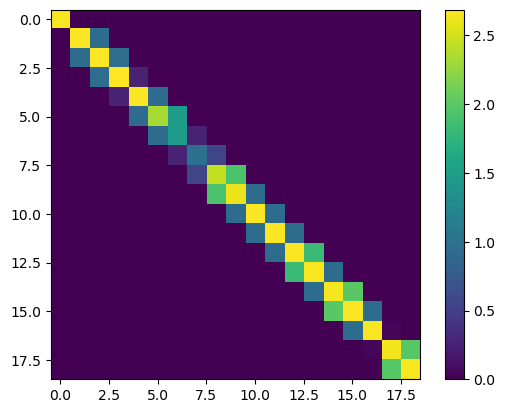

In [55]:
plt.imshow(c_mat)
plt.colorbar()
plt.show()

#eta
#b_mat

In [31]:
array_variance[~np.isfinite(array_variance)]

array([], dtype=float64)

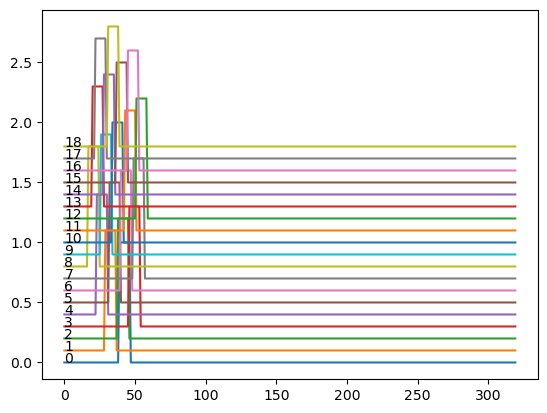

In [30]:
for i in range(0,len(eta)):
    
    plt.plot(np.add(eta[str(i)],0.1*i))
    plt.annotate(str(i), (0,0.1*i), xytext=None)

plt.savefig('junk_19specs2.png')
plt.show()

In [16]:
c_mat = np.zeros((19,19), dtype='float')

In [28]:
for i in range(0,len(eta)):
    
    plt.plot(eta[str(i)])

plt.show()

In [74]:
plt.imshow(bb_array, origin='lower')
plt.show()